In [1]:
!nvidia-smi

Sun May  9 16:43:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:09:00.0  On |                  N/A |
| 32%   58C    P0    68W / 250W |    645MiB / 11175MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3080    Off  | 00000000:0A:00.0 Off |                  N/A |
| 53%   

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, UpSampling2D, Concatenate, Dense, BatchNormalization, Dropout, MaxPool2D, Input, SeparableConv2D, Lambda, Activation, Add
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import backend as K

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [4]:
!ls /tmp

Notebooks	 data		      tmp23uafz9t.py  tmpruafdkjf.py
README.md	 data_collection_vio  tmp5ewht9o8.py  tmpv9y_q_a2.py
ReadingMaterial  tmp082p5vm3.py       tmpj9t2h725     tmpw5a0y9da.py
__pycache__	 tmp1cczk17o.py       tmpmy4pxrsc.py  tmpxcwdhfye.py


In [5]:
import pathlib
import os

In [6]:
data_dir = pathlib.Path('/tmp/data/nyu2_train')

In [7]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*.jpg'), shuffle=False)

In [107]:
for f in list_ds.take(5):
    print(f)

tf.Tensor(b'/tmp/data/nyu2_train/basement_0001a_out/1.jpg', shape=(), dtype=string)
tf.Tensor(b'/tmp/data/nyu2_train/basement_0001a_out/10.jpg', shape=(), dtype=string)
tf.Tensor(b'/tmp/data/nyu2_train/basement_0001a_out/100.jpg', shape=(), dtype=string)
tf.Tensor(b'/tmp/data/nyu2_train/basement_0001a_out/101.jpg', shape=(), dtype=string)
tf.Tensor(b'/tmp/data/nyu2_train/basement_0001a_out/102.jpg', shape=(), dtype=string)


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

In [9]:
img_height = 128
img_width = 128

In [110]:
def get_depth(file_path):
    return tf.strings.regex_replace(file_path, 'jpg', 'png')

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3) / 255
    # resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width], antialias=True)

def decode_png(depth):
    depth = tf.image.decode_png(depth, channels=1)
    d_mean = tf.experimental.numpy.nanmean(depth)
    depth = tf.experimental.numpy.where(depth == 0, d_mean, depth)
    depth = depth / 255
    return tf.image.resize(depth, [img_height, img_width], antialias=True)

def process_path(file_path):
    depth_path = get_depth(file_path)
    # load the raw data from the file as a string
    rgb = tf.io.read_file(file_path)
    depth = tf.io.read_file(depth_path)
#     print(file_path)
#     print(depth_path)
    rgb = decode_img(rgb)
    depth = decode_png(depth)
    return rgb, depth

In [74]:
def test_process(file_path):
    print(file_path)
    return file_path

In [111]:
def configure_for_performance(ds, batch_=32):
#     ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [112]:
train_ds = list_ds.take(10).map(process_path, num_parallel_calls=AUTOTUNE)

In [99]:
for f, d in train_ds.take(5):
    print(f.numpy().astype('uint8').shape)
    print(d.shape)

(128, 128, 3)
(128, 128, 1)
(128, 128, 3)
(128, 128, 1)
(128, 128, 3)
(128, 128, 1)
(128, 128, 3)
(128, 128, 1)
(128, 128, 3)
(128, 128, 1)


In [113]:
train_ds = configure_for_performance(train_ds)

In [117]:
for img, depth in train_ds.take(1):
    print(img.numpy() * 255)

[[[[249.45363   250.87755   248.31635  ]
   [249.54042   249.349     250.89882  ]
   [251.47145   251.52368   248.77348  ]
   ...
   [248.42166   250.1237    247.68532  ]
   [252.11104   249.17268   250.37105  ]
   [253.20549   251.28294   253.27182  ]]

  [[245.7039    246.73329   244.64922  ]
   [168.65132   170.14052   171.01698  ]
   [129.24638   131.80177   131.47151  ]
   ...
   [123.79719   131.39542   116.55222  ]
   [195.78903   196.56885   191.34193  ]
   [250.14157   251.85074   252.17978  ]]

  [[243.9891    244.3274    243.16531  ]
   [121.932396  125.71291   125.2354   ]
   [ 88.60036    94.92389    99.02442  ]
   ...
   [ 23.786903   33.66797    13.876462 ]
   [113.56      115.500885  106.8361   ]
   [251.09933   253.80327   251.99153  ]]

  ...

  [[250.70915   250.70915   250.9489   ]
   [192.05734   192.05734   193.10265  ]
   [171.06763   171.3076    172.17522  ]
   ...
   [ 80.448875   84.12144    61.180553 ]
   [145.96179   147.4687    137.12463  ]
   [253.28036   

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)


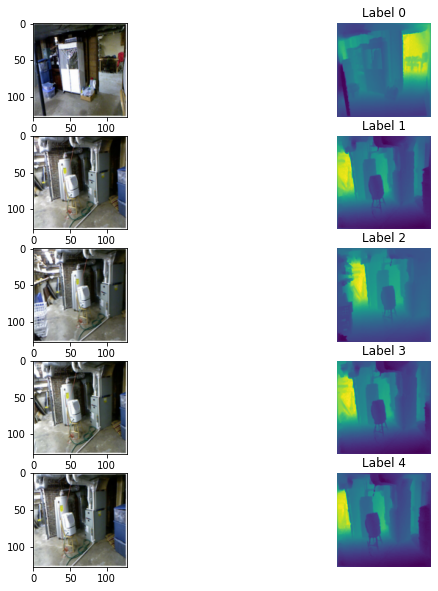

In [119]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(5):
    ax1 = plt.subplot(5, 2, (i * 2) + 1)
    print(image_batch[i].numpy().shape)
    img = image_batch[i].numpy() * 255
    ax1.imshow(img.astype("uint8"))
    ax2 = plt.subplot(5, 2, (i * 2) + 2)
    ax2.imshow((label_batch[i].numpy() * 255).astype("uint8"))
#     label = label_batch[i]
    plt.title("Label {}".format(i))
    plt.axis("off")


In [151]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*.jpg'), shuffle=False)

In [152]:
img_count = tf.data.experimental.cardinality(list_ds).numpy()
print(img_count)

50688


In [153]:
val_size = int(img_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [29]:
for f in train_ds.take(5):
    print(f)

tf.Tensor(b'/tmp/data/nyu2_train/bedroom_0076a_out/149.jpg', shape=(), dtype=string)
tf.Tensor(b'/tmp/data/nyu2_train/bedroom_0076a_out/15.jpg', shape=(), dtype=string)
tf.Tensor(b'/tmp/data/nyu2_train/bedroom_0076a_out/150.jpg', shape=(), dtype=string)
tf.Tensor(b'/tmp/data/nyu2_train/bedroom_0076a_out/151.jpg', shape=(), dtype=string)
tf.Tensor(b'/tmp/data/nyu2_train/bedroom_0076a_out/152.jpg', shape=(), dtype=string)


In [154]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

40551
10137


In [155]:
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [156]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [157]:
def upBlock(x, skip, filters, kernel_s=(5,5),
               padding_='same', strides_= 1,
               activation_='relu', name='upblock'):
    padding = 4 // 2  # kernelsize - 1// 2
    conv1 = SeparableConv2D(filters, kernel_size=kernel_s,
                          padding='same', strides=strides_,
                          kernel_initializer='he_uniform',
                          activation=activation_, name='{}_conv'.format(name))(x)
    x = UpSampling2D((2,2), interpolation='nearest')(conv1)
    if skip is not None:
        x = x + skip
    return x

def mobilenet_model(input_shape):
    inputs = Input(input_shape)
    
    '''Load pre-trained MobileNet'''
    mobilenet = MobileNet(include_top=False, weights='imagenet', input_tensor=inputs)
    
    '''Decoder'''
    mobilenet_final_output_shape = mobilenet.layers[-1].output.shape
    decode_filters = int(mobilenet_final_output_shape[-1])
    decoder = Conv2D(filters=decode_filters, kernel_size=1, padding='same', input_shape=mobilenet_final_output_shape, name='decoder_conv_1')(mobilenet.output)
    
    decoder = upBlock(decoder, None, int(decode_filters / 2), name='uplock_1')
    decoder = upBlock(decoder, mobilenet.layers[30].output, int(decode_filters / 4), name='uplock_2')
    decoder = upBlock(decoder, mobilenet.layers[17].output, int(decode_filters / 8), name='uplock_3')
    decoder = upBlock(decoder, mobilenet.layers[7].output, int(decode_filters / 16), name='uplock_4')
    decoder = upBlock(decoder, None, int(decode_filters/32), name='upblock_5')
#     decoder = upBlockPointWise(decoder, None, int(decode_filters/32), name='upblock_6')
    
    # conv_dw_1 x1 4, conv_dw_3 x2, conv_dw_5 x3
    
    outputs = Conv2D(1, kernel_size=(1,1), padding='same', name='decoder_final_conv')(decoder)
    outputs = Activation(activation='relu')(outputs)
    model = keras.models.Model(inputs, outputs)
    return model

In [158]:
model = mobilenet_model((128, 128, 3))

In [159]:
def ssmi_loss1(y_true, y_pred):
    print(y_true.shape)
    print(y_pred.shape)
#     y_true = tf.expand_dims(y_true, -1)
#     y_pred = tf.expand_dims(y_pred, -1)
    ssim = tf.image.ssim(y_true, y_pred, 
                            max_val=4.0, 
                            filter_size=11,
                            filter_sigma=1.5,
                            k1=0.01,
                            k2=0.03)
    loss1 = tf.keras.losses.mean_squared_error(y_true, y_pred)
    # loss3 = tf.keras.losses.mean_absolute_error(y_true, y_pred)
    loss2 = tf.reduce_mean(1-ssim)
    return loss2*0.7+loss1*0.3

In [160]:
model.compile(optimizer='adam', loss=ssmi_loss1, metrics=['acc'])

In [161]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./tmp/mobilenet")

In [162]:
%load_ext tensorboard

In [163]:
%tensorboard --logdir tmp/mobilenet

In [164]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"
model.fit(train_ds, validation_data=val_ds, epochs=200, verbose=1, callbacks=[tensorboard_callback])

Epoch 1/200
(None, 128, 128, 1)
(None, 128, 128, 1)
(None, 128, 128, 1)
(None, 128, 128, 1)
1267/1268 [============================>.] - ETA: 0s - loss: 0.0768 - acc: 3.0739e-09(None, 128, 128, 1)
(None, 128, 128, 1)
1268/1268 [==============================] - 154s 117ms/step - loss: 0.0767 - acc: 3.0714e-09 - val_loss: 0.0479 - val_acc: 0.0000e+00
Epoch 2/200
1268/1268 [==============================] - 144s 112ms/step - loss: 0.0299 - acc: 3.1657e-09 - val_loss: 0.0366 - val_acc: 0.0000e+00
Epoch 3/200
1268/1268 [==============================] - 142s 111ms/step - loss: 0.0245 - acc: 3.3192e-09 - val_loss: 0.0330 - val_acc: 0.0000e+00
Epoch 4/200
1268/1268 [==============================] - 142s 111ms/step - loss: 0.0209 - acc: 2.9913e-09 - val_loss: 0.0337 - val_acc: 0.0000e+00
Epoch 5/200
1268/1268 [==============================] - 142s 111ms/step - loss: 0.0187 - acc: 2.8351e-09 - val_loss: 0.0334 - val_acc: 0.0000e+00
Epoch 6/200
1268/1268 [==============================] - 143

In [165]:
test_img = '/tmp/data/nyu2_test/00016_colors.png'
depth_img = '/tmp/data/nyu2_test/00016_depth.png'

In [166]:
import cv2
img =cv2.imread(test_img)
img = cv2.resize(img, (128, 128))
# img = img/float(255.0)
img = np.array(img)

In [167]:
dimg =cv2.imread(depth_img)
dimg = cv2.resize(dimg, (128, 128))
dimg = dimg/np.max(dimg)
dimg = np.array(dimg)

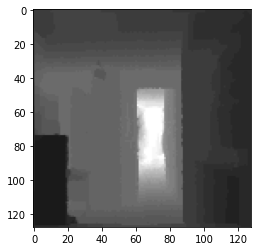

In [168]:
plt.imshow(dimg)

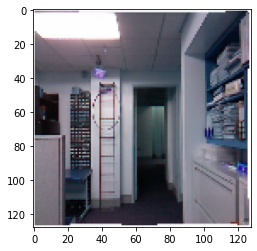

In [169]:
plt.imshow(img)

In [170]:
img.shape

(128, 128, 3)

In [173]:
preds = model.predict(np.expand_dims(img / 255.0, axis=0))

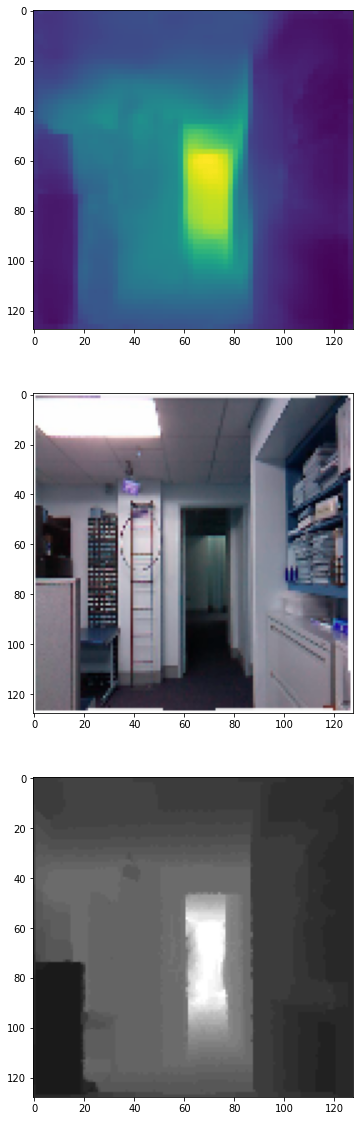

In [174]:
plt.figure(figsize=(20, 20))
prds1 = np.reshape(preds[0], newshape=(preds[0].shape[0]*preds[0].shape[1]))
plt.subplot(3,1,1)
plt.imshow(np.reshape(prds1, newshape=(128, 128))*255)
plt.subplot(3,1,2)
plt.imshow(img)
plt.subplot(3,1,3)
plt.imshow(dimg)

## Running Predict on DIML single image as test

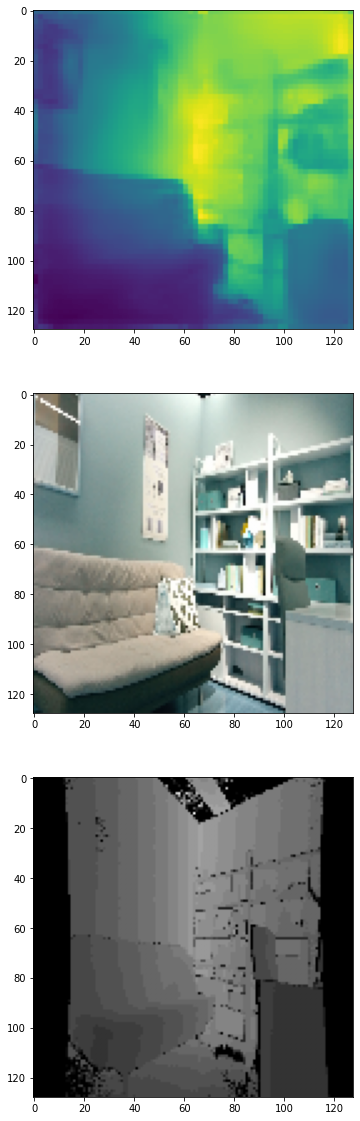

In [177]:
test_img = '/tmp/Notebooks/ssuwal/train-data/rgb/in_00_160216_122936_c.png'
depth_img = '/tmp/Notebooks/ssuwal/train-data/depth/in_00_160216_122936_depth_raw.png'

import cv2
img =cv2.imread(test_img)
img = cv2.resize(img, (128, 128))
# img = img/float(255.0)
img = np.array(img) / 255.0

dimg =cv2.imread(depth_img)
dimg = cv2.resize(dimg, (128, 128))
dimg = dimg/np.max(dimg)
dimg = np.array(dimg)


preds = model.predict(np.expand_dims(img, axis=0))


plt.figure(figsize=(20, 20))
prds1 = np.reshape(preds[0], newshape=(preds[0].shape[0]*preds[0].shape[1]))
plt.subplot(3,1,1)
plt.imshow(np.reshape(prds1, newshape=(128, 128))*255)
plt.subplot(3,1,2)
plt.imshow(img)
plt.subplot(3,1,3)
plt.imshow(dimg)

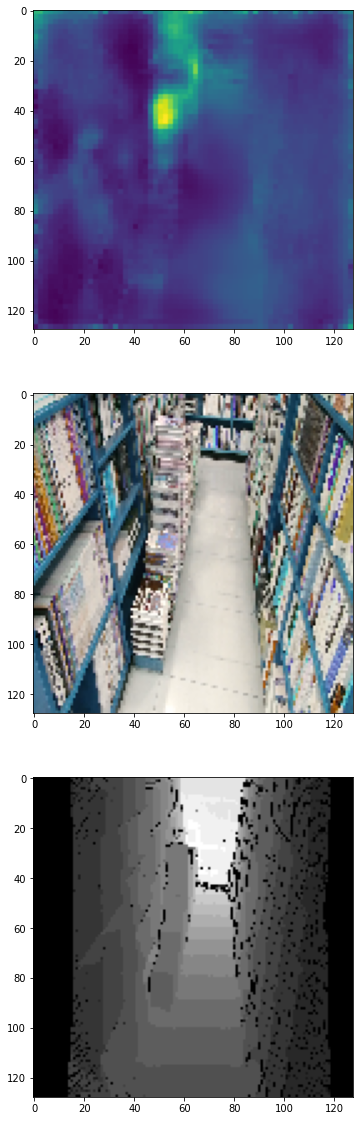

In [207]:
# in_03_160317_172443_c.png

test_img = '/tmp/Notebooks/ssuwal/train-data/rgb/in_03_160317_172443_c.png'
depth_img = '/tmp/Notebooks/ssuwal/train-data/depth/in_03_160317_172443_depth_raw.png'

import cv2
img =cv2.imread(test_img)
img = cv2.resize(img, (128, 128))
# img = img/float(255.0)
img = np.array(img) / 255.0

dimg =cv2.imread(depth_img)
dimg = cv2.resize(dimg, (128, 128))
dimg = dimg/np.max(dimg)
dimg = np.array(dimg)


preds = model.predict(np.expand_dims(img, axis=0))


plt.figure(figsize=(20, 20))
prds1 = np.reshape(preds[0], newshape=(preds[0].shape[0]*preds[0].shape[1]))
plt.subplot(3,1,1)
plt.imshow(np.reshape(prds1, newshape=(128, 128))*255)
plt.subplot(3,1,2)
plt.imshow(img)
plt.subplot(3,1,3)
plt.imshow(dimg,  cmap=plt.cm.viridis)